In [132]:
# Imports
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils_leon

# Create Training and Test Sets

In [3]:
# Define label dictionary - 20 classes
syncs = [  "0-50 ms",   "51-100 ms", "101-150 ms", "151-200 ms", "201-250 ms",
         "251-300 ms", "301-350 ms", "351-400 ms", "401-450 ms", "451-500 ms", 
         "501-550 ms", "551-600 ms", "601-650 ms", "651-700 ms", "701-750 ms", 
         "751-800 ms", "801-850 ms", "851-900 ms", "901-950 ms", "951-1000 ms" ]
sync_dict = {}

count = 0
for sync_val in syncs:
    sync_dict[sync_val] = count
    count += 1

# preview dictionary
sync_dict

{'0-50 ms': 0,
 '51-100 ms': 1,
 '101-150 ms': 2,
 '151-200 ms': 3,
 '201-250 ms': 4,
 '251-300 ms': 5,
 '301-350 ms': 6,
 '351-400 ms': 7,
 '401-450 ms': 8,
 '451-500 ms': 9,
 '501-550 ms': 10,
 '551-600 ms': 11,
 '601-650 ms': 12,
 '651-700 ms': 13,
 '701-750 ms': 14,
 '751-800 ms': 15,
 '801-850 ms': 16,
 '851-900 ms': 17,
 '901-950 ms': 18,
 '951-1000 ms': 19}

### Load real edited videos
Define classes and preview

In [172]:
# Specify directories
frame_folder = "./data/frames"

# Construct X = folder names, y = the label
vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label) # x 100 + 100
    
# create pytorch dataset class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
        
# Display video count and classes
len(X_paths), len(y), Counter(y)

Current Video: video3
Current Video: video4
Current Video: video2
Current Video: video1


(504,
 504,
 Counter({3: 50,
          4: 50,
          6: 48,
          1: 54,
          5: 51,
          8: 52,
          2: 49,
          9: 52,
          0: 48,
          7: 50}))

### Load synthetically created feature points
Define classes and preview

In [716]:
# define synthetic data directory
output_dir = 'synthetic_data/output'
output_list = os.listdir(output_dir)

X_paths = [] # paths of segment folders
y = [] # designated label

for output_folder in output_list:
    if output_folder.startswith('vid'):
        x_path = output_dir + '/' + output_folder
        X_paths.append(x_path)
        
        # Extract class label from folder name
        params = re.findall(r'\d+', output_folder)
        label = int(int(params[3]) / 200)
        y.append(label)
        
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        # extract features
        X_pts = data['subset_all'].reshape(data['subset_all'].shape[0],60)
        X_feat = data['candidate_all']
        for frame in range(X_pts.shape[0]):
            X_occluded = np.where(X_pts[frame] == -1)
            X_feat[frame][X_pts[frame] == -1, :] = -1
        # only use body markers 0-17
        non_markers = [18,19,38,39,58,59]
        X_feat = X_feat[:20,:,0:2] # use 50 frames # try reshaping into 3 channels
        X_feat[:,0:17,0] -= np.mean(X_feat[:,0:17,0])
        X_feat[:,0:17,0] /= np.std(X_feat[:,0:17,0])
        X_feat[:,20:37,0] -= np.mean(X_feat[:,20:37,0])
        X_feat[:,20:37,0] /= np.std(X_feat[:,20:37,0])
        X_feat[:,40:57,0] -= np.mean(X_feat[:,40:57,0])
        X_feat[:,40:57,0] /= np.std(X_feat[:,40:57,0])
        X_feat[:,0:17,1] -= np.mean(X_feat[:,0:17,1])
        X_feat[:,0:17,1] /= np.std(X_feat[:,0:17,1])
        X_feat[:,20:37,1] -= np.mean(X_feat[:,20:37,1])
        X_feat[:,20:37,1] /= np.std(X_feat[:,20:37,1])
        X_feat[:,40:57,1] -= np.mean(X_feat[:,40:57,1])
        X_feat[:,40:57,1] /= np.std(X_feat[:,40:57,1])
        X_feat = np.squeeze(np.delete(X_feat, non_markers, axis=1).reshape(20,-1))
        
        # Convert X to tensor
        X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
    
# Display video count and classes
len(X_paths), len(y), Counter(y)

(854, 854, Counter({0: 128, 4: 170, 2: 172, 5: 43, 3: 169, 1: 172}))

# Create Pytorch Dataset
## Load data
Split into training and test (apply transform if applicable)

In [173]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


In [286]:
# define normalization
class norm_per_keypt(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        sub1 = normalize(sample[:,0:56], axis=1)
        sub2 = normalize(sample[:,56:112], axis=1)
        sub3 = normalize(sample[:,112:168], axis=1)
        # recombine subjects
        scaled_sample = np.concatenate((sub1, sub2, sub3),axis=1)
        return scaled_sample
    
class norm_over_frames(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = normalize(sample, axis=1)
        return scaled_sample
    
class norm_over_all(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = normalize(sample)
        return scaled_sample
    
dataset = []
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
for train_X, train_y in training_dataset:
    new_row = train_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
saved_mean = np.mean(dataset, axis=0) 
saved_std = np.std(dataset, axis=0), 

class norm_with_saved(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [287]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    norm_with_saved(),
    transforms.ToTensor(),
])

# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)

In [288]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y
sample_X[2,0:3]

tensor([1.3579, 1.1261, 0.1960])

## Define Data Loader  
Data Loader for extracting batches from the Pytorch Dataset during model training

In [289]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [290]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

# check shapes
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


# Model Definition 

In [291]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168 #108 #168
        batchsize = 1
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        self.h0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial hidden state
        self.c0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial cell state
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame, (self.h0, self.c0))
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        
        return output

# Model Training  

Define loss function and optimizer to train the model

Table of tested params:

|  S/N  |  data  |  dr  |  layers  |  hidden_size  |  epochs  |   lr   |    loss     |  train_acc  |  test_acc | 
|-------|--------|------|----------|---------------|----------|--------|-------------|-------------|-----------|
|   1   |  real  |   0  |    1     |      300      |    100   |  3e-3  |   CE: 2.28  |      13     |     13    |
|   2   |  syn   |   0  |    1     |      300      |    30    |  3e-3  |   CE: 2.6   |      10     |     10    |
|   3   |  syn   |   0  |    1     |      300      |    30    |  0.1   |   CE: 2.45  |      10     |     10    |
|   4   |  syn   |   0  |    1     |      100      |    30    |  0.1   |   CE: 2.39  |      10     |     10    |
|   5   |  syn   |   0  |    1     |      100      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   6   |  syn   |   0  |    1     |      300      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   7   |  syn   |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 8.04  |      9.8    |     9.8   |
|   8   |  real  |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 20.7  |      9.8    |     9.8   |
|   9   |  real  |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      7.8    |     7.8   |
|   10  |r_inorm |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      9.8    |     9.8   |
|   11  |r_fnorm |   0  |    1     |      100      |    70    |  0.1   |  MSE: 8.3   |      9.8    |     9.8   |
|   12  |r_snorm |   0  |    1     |      100      |    70    |  0.1   |   CE: 1.5   |      40     |     19    |
|   12  |r_snorm |   0  |    1     |      100      |    70    |  0.1   |  MSE: 1.5   |      23.    |     23.5  |

In [309]:
# RNN Model Parameter
model_params = {
    "num_classes": 10,
    "dr_rate": 0.0,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
}
model = SyncRNN(model_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Print Model Params
model = model.to(device)
model

cpu


SyncRNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(168, 100)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
)

In [310]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.randn(1, 20, 168)
    y = model(x)
    print(y.shape) # should be [1,10]

torch.Size([1, 1, 10])


In [313]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(reduction="sum")
#loss_fn = nn.MSELoss(reduction="sum")

# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 0.1) #3e-5 # 3e-3

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 70,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights_real_ce.pt",
}

In [314]:
trained_model, loss_hist, metric_hist = trainutils_leon.train_model(model, train_params)

Epoch 0/69, current_lr=0.1



Saved best model weights
Train Loss: 2.828090, Dev Loss: 3.108781, Accuracy: 7.84
----------
Epoch 1/69, current_lr=0.1



Saved best model weights
Train Loss: 2.722902, Dev Loss: 3.084847, Accuracy: 7.84
----------
Epoch 2/69, current_lr=0.1



Train Loss: 2.625561, Dev Loss: 3.093773, Accuracy: 7.84
----------
Epoch 3/69, current_lr=0.1



Saved best model weights
Train Loss: 2.638965, Dev Loss: 2.718522, Accuracy: 13.73
----------
Epoch 4/69, current_lr=0.1



Train Loss: 2.492288, Dev Loss: 2.740616, Accuracy: 17.65
----------
Epoch 5/69, current_lr=0.1



Train Loss: 2.514185, Dev Loss: 3.223888, Accuracy: 7.84
----------
Epoch 6/69, current_lr=0.1



Train Loss: 2.523219, Dev Loss: 3.119277, Accuracy: 1.96
----------
Epoch 7/69, current_lr=0.1



Train Loss: 2.347312, Dev Loss: 3.035100, Accuracy: 11.76
----------
Epoch 8/69, current_lr=0.1



Train Loss: 2.413767, Dev Loss: 2.776054, Accuracy: 7.84
----------
Epoch 9/69, current_lr=0.1



Epoch     9: reducing learning rate of group 0 to 7.0000e-02.
Loading best model weights
Train Loss: 2.529270, Dev Loss: 3.274755, Accuracy: 9.80
----------
Epoch 10/69, current_lr=0.06999999999999999



Train Loss: 2.351470, Dev Loss: 2.734054, Accuracy: 21.57
----------
Epoch 11/69, current_lr=0.06999999999999999



Train Loss: 2.316550, Dev Loss: 2.968171, Accuracy: 5.88
----------
Epoch 12/69, current_lr=0.06999999999999999



Train Loss: 2.223189, Dev Loss: 3.073080, Accuracy: 3.92
----------
Epoch 13/69, current_lr=0.06999999999999999



Saved best model weights
Train Loss: 2.233511, Dev Loss: 2.550171, Accuracy: 11.76
----------
Epoch 14/69, current_lr=0.06999999999999999



Train Loss: 2.170813, Dev Loss: 2.723989, Accuracy: 3.92
----------
Epoch 15/69, current_lr=0.06999999999999999



Train Loss: 2.093504, Dev Loss: 2.853259, Accuracy: 3.92
----------
Epoch 16/69, current_lr=0.06999999999999999



Train Loss: 1.976583, Dev Loss: 2.740738, Accuracy: 19.61
----------
Epoch 17/69, current_lr=0.06999999999999999



Train Loss: 2.106765, Dev Loss: 3.027356, Accuracy: 5.88
----------
Epoch 18/69, current_lr=0.06999999999999999



Train Loss: 2.053523, Dev Loss: 2.921504, Accuracy: 3.92
----------
Epoch 19/69, current_lr=0.06999999999999999



Epoch    19: reducing learning rate of group 0 to 4.9000e-02.
Loading best model weights
Train Loss: 2.059035, Dev Loss: 2.967040, Accuracy: 13.73
----------
Epoch 20/69, current_lr=0.048999999999999995



Train Loss: 2.084882, Dev Loss: 2.703516, Accuracy: 9.80
----------
Epoch 21/69, current_lr=0.048999999999999995



Saved best model weights
Train Loss: 1.954426, Dev Loss: 2.484988, Accuracy: 17.65
----------
Epoch 22/69, current_lr=0.048999999999999995



Train Loss: 1.955008, Dev Loss: 2.698858, Accuracy: 17.65
----------
Epoch 23/69, current_lr=0.048999999999999995



Train Loss: 1.906924, Dev Loss: 2.652092, Accuracy: 7.84
----------
Epoch 24/69, current_lr=0.048999999999999995



Train Loss: 1.927753, Dev Loss: 2.845570, Accuracy: 5.88
----------
Epoch 25/69, current_lr=0.048999999999999995



Train Loss: 1.854576, Dev Loss: 2.806297, Accuracy: 5.88
----------
Epoch 26/69, current_lr=0.048999999999999995



Train Loss: 1.845345, Dev Loss: 2.561094, Accuracy: 13.73
----------
Epoch 27/69, current_lr=0.048999999999999995



Epoch    27: reducing learning rate of group 0 to 3.4300e-02.
Loading best model weights
Train Loss: 1.845443, Dev Loss: 2.500103, Accuracy: 11.76
----------
Epoch 28/69, current_lr=0.0343



Train Loss: 1.858944, Dev Loss: 2.743400, Accuracy: 9.80
----------
Epoch 29/69, current_lr=0.0343



Train Loss: 1.816821, Dev Loss: 2.577029, Accuracy: 11.76
----------
Epoch 30/69, current_lr=0.0343



Train Loss: 1.806388, Dev Loss: 2.526543, Accuracy: 15.69
----------
Epoch 31/69, current_lr=0.0343



Train Loss: 1.779453, Dev Loss: 2.834084, Accuracy: 13.73
----------
Epoch 32/69, current_lr=0.0343



Train Loss: 1.691862, Dev Loss: 2.547342, Accuracy: 11.76
----------
Epoch 33/69, current_lr=0.0343



Epoch    33: reducing learning rate of group 0 to 2.4010e-02.
Loading best model weights
Train Loss: 1.678617, Dev Loss: 2.630079, Accuracy: 19.61
----------
Epoch 34/69, current_lr=0.024009999999999997



Train Loss: 1.831917, Dev Loss: 2.705982, Accuracy: 13.73
----------
Epoch 35/69, current_lr=0.024009999999999997



Train Loss: 1.779446, Dev Loss: 2.732604, Accuracy: 11.76
----------
Epoch 36/69, current_lr=0.024009999999999997



Train Loss: 1.727783, Dev Loss: 2.675487, Accuracy: 15.69
----------
Epoch 37/69, current_lr=0.024009999999999997



Train Loss: 1.694524, Dev Loss: 2.621513, Accuracy: 15.69
----------
Epoch 38/69, current_lr=0.024009999999999997



Train Loss: 1.675256, Dev Loss: 2.821149, Accuracy: 15.69
----------
Epoch 39/69, current_lr=0.024009999999999997



Epoch    39: reducing learning rate of group 0 to 1.6807e-02.
Loading best model weights
Train Loss: 1.553094, Dev Loss: 2.579895, Accuracy: 13.73
----------
Epoch 40/69, current_lr=0.016806999999999996



Train Loss: 1.808735, Dev Loss: 2.517888, Accuracy: 23.53
----------
Epoch 41/69, current_lr=0.016806999999999996



Train Loss: 1.799510, Dev Loss: 2.569329, Accuracy: 15.69
----------
Epoch 42/69, current_lr=0.016806999999999996



Saved best model weights
Train Loss: 1.727631, Dev Loss: 2.456877, Accuracy: 17.65
----------
Epoch 43/69, current_lr=0.016806999999999996



Train Loss: 1.707928, Dev Loss: 2.501353, Accuracy: 21.57
----------
Epoch 44/69, current_lr=0.016806999999999996



Train Loss: 1.630252, Dev Loss: 2.514526, Accuracy: 15.69
----------
Epoch 45/69, current_lr=0.016806999999999996



Train Loss: 1.645343, Dev Loss: 2.506977, Accuracy: 15.69
----------
Epoch 46/69, current_lr=0.016806999999999996



Train Loss: 1.605976, Dev Loss: 2.777643, Accuracy: 9.80
----------
Epoch 47/69, current_lr=0.016806999999999996



Train Loss: 1.507511, Dev Loss: 2.525299, Accuracy: 15.69
----------
Epoch 48/69, current_lr=0.016806999999999996



Epoch    48: reducing learning rate of group 0 to 1.1765e-02.
Loading best model weights
Train Loss: 1.495935, Dev Loss: 2.579527, Accuracy: 21.57
----------
Epoch 49/69, current_lr=0.011764899999999997



Train Loss: 1.671370, Dev Loss: 2.692019, Accuracy: 11.76
----------
Epoch 50/69, current_lr=0.011764899999999997



Train Loss: 1.628912, Dev Loss: 2.493772, Accuracy: 19.61
----------
Epoch 51/69, current_lr=0.011764899999999997



Saved best model weights
Train Loss: 1.624080, Dev Loss: 2.396476, Accuracy: 15.69
----------
Epoch 52/69, current_lr=0.011764899999999997



Train Loss: 1.628559, Dev Loss: 2.521185, Accuracy: 15.69
----------
Epoch 53/69, current_lr=0.011764899999999997



Train Loss: 1.542285, Dev Loss: 2.478172, Accuracy: 17.65
----------
Epoch 54/69, current_lr=0.011764899999999997



Train Loss: 1.532128, Dev Loss: 2.471922, Accuracy: 21.57
----------
Epoch 55/69, current_lr=0.011764899999999997



Train Loss: 1.527316, Dev Loss: 2.743992, Accuracy: 11.76
----------
Epoch 56/69, current_lr=0.011764899999999997



Train Loss: 1.474898, Dev Loss: 2.628941, Accuracy: 15.69
----------
Epoch 57/69, current_lr=0.011764899999999997



Epoch    57: reducing learning rate of group 0 to 8.2354e-03.
Loading best model weights
Train Loss: 1.486778, Dev Loss: 2.632252, Accuracy: 13.73
----------
Epoch 58/69, current_lr=0.008235429999999997



Train Loss: 1.574780, Dev Loss: 2.525014, Accuracy: 15.69
----------
Epoch 59/69, current_lr=0.008235429999999997



Train Loss: 1.535704, Dev Loss: 2.615474, Accuracy: 9.80
----------
Epoch 60/69, current_lr=0.008235429999999997



Train Loss: 1.537659, Dev Loss: 2.520277, Accuracy: 15.69
----------
Epoch 61/69, current_lr=0.008235429999999997



Train Loss: 1.523366, Dev Loss: 2.569712, Accuracy: 9.80
----------
Epoch 62/69, current_lr=0.008235429999999997



Train Loss: 1.479221, Dev Loss: 2.433965, Accuracy: 13.73
----------
Epoch 63/69, current_lr=0.008235429999999997



Epoch    63: reducing learning rate of group 0 to 5.7648e-03.
Loading best model weights
Train Loss: 1.438471, Dev Loss: 2.397566, Accuracy: 23.53
----------
Epoch 64/69, current_lr=0.005764800999999997



Train Loss: 1.571207, Dev Loss: 2.496605, Accuracy: 19.61
----------
Epoch 65/69, current_lr=0.005764800999999997



Train Loss: 1.567362, Dev Loss: 2.602582, Accuracy: 9.80
----------
Epoch 66/69, current_lr=0.005764800999999997



Train Loss: 1.509452, Dev Loss: 2.688370, Accuracy: 15.69
----------
Epoch 67/69, current_lr=0.005764800999999997



Train Loss: 1.526972, Dev Loss: 2.470158, Accuracy: 17.65
----------
Epoch 68/69, current_lr=0.005764800999999997



Train Loss: 1.501985, Dev Loss: 2.723669, Accuracy: 15.69
----------
Epoch 69/69, current_lr=0.005764800999999997



Epoch    69: reducing learning rate of group 0 to 4.0354e-03.
Loading best model weights
Train Loss: 1.517275, Dev Loss: 2.603834, Accuracy: 13.73
----------


In [315]:
# check output
for xb, yb in training_loader:
    with torch.no_grad():
        x = xb
        y = model(x)
        idx = y.argmax(dim=2)
        print(idx)
    break

tensor([[5],
        [7],
        [6],
        [4],
        [1],
        [5],
        [7],
        [0],
        [4],
        [2],
        [8],
        [0],
        [0],
        [0],
        [8],
        [9],
        [7],
        [6],
        [6],
        [9],
        [6],
        [4],
        [4],
        [8],
        [7],
        [4],
        [0],
        [6],
        [8],
        [5]])


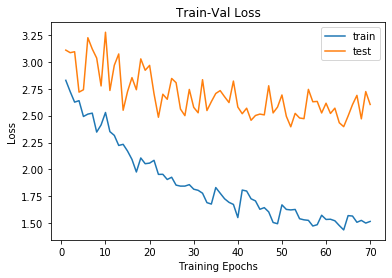

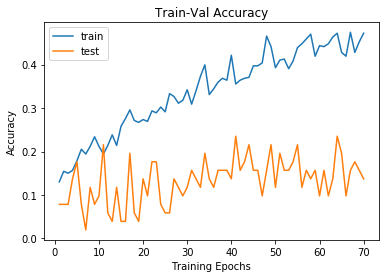

In [316]:
trainutils_leon.plot_loss(loss_hist, metric_hist)